## Do the Estimation with SCE and SPF data


### 1. Importing estimation modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg as AR
#from UCSVEst import UCSVEst as ucsv

In [2]:
from GMMEst_Dev import RationalExpectation as re
from GMMEst import StickyExpectation as seb
from GMMEst import NoisyInformation as nib
#from GMMEst import ParameterLearning as pl
from GMMEst_Dev import AR1_simulator, ForecastPlotDiag, ForecastPlot

In [3]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

### 2. Preparing real-time data 

In [4]:
## CPI Core
InfCPICMRT=pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT=pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [5]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [6]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [7]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [8]:
## turn index into yearly inflation
real_time_index =pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [9]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [10]:
## exapectation data from SPF 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str,freq='infer')

####################################################
#### specific to including more moments ###########
####################################################
SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var',
               'SPFCPI_ATV','SPFCPI_FEATV']].dropna(how='any')

In [11]:
## Inflation data quarterly 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2.dt.year.astype(int).astype(str) + \
             "Q" + dateQ2.dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')

In [12]:
## process parameters estimation 
# period filter 
start_t='1995-01-01'
end_t = '2019-03-30'   

### quarterly data 
CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]
Y = np.array(CPICQ[1:])
X = np.array(CPICQ[:-1])

ARmodel = AR(CPICQ,
             lags = 1,
             trend = 'n')
ar_rs = ARmodel.fit()
rhoQ_est = ar_rs.params[0]
sigmaQ_est = np.sqrt(sum(ar_rs.resid**2)/(len(CPICQ)-1))
print('Quarterly CPI core inflation AR1 model estimates are '+ str([rhoQ_est,sigmaQ_est]))

Quarterly CPI core inflation AR1 model estimates are [0.9899411115512828, 0.22732275214532127]


In [13]:
## Inflation data monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [14]:
### monthly data 
CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]
Y = np.array(CPIM[1:])
X = np.array(CPIM[:-1])

ARmodel2 = AR(CPIM,
             lags = 1, 
             trend = 'n')
ar_rs2 = ARmodel2.fit()
rhoM_est = ar_rs2.params[0]
sigmaM_est = np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))
print('Monthly CPI AR1 model estimates are '+ str([rhoM_est,sigmaM_est]))

Monthly CPI AR1 model estimates are [0.9850821376576725, 0.411456441087024]


In [15]:
## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')

PopM = PopM[-PopM.date.isnull()]

dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')

dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM,freq='infer')

####################################################
#### specific to including more moments ###########
####################################################

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var',
              'SCE_ATV','SCE_FEATV']].dropna(how='any')

In [16]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,InfQ['Inf1y_CPICore'],InfQ['Inf1yf_CPICore']], join='inner', axis=1)
SCE_est = pd.concat([SCECPI,real_time_inf,InfM['Inf1yf_CPIAU']], join='inner', axis=1)

In [17]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

historyQ = real_time_inf.copy().loc[st_t_history:ed_t_SPF]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

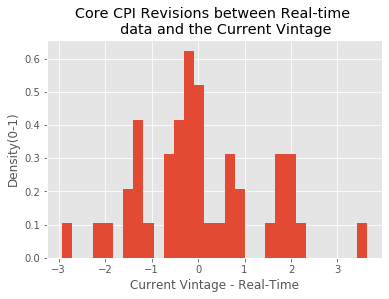

In [18]:
# How large is the difference between current vintage and real-time data
rev = SPF_est['Inf1y_CPICore'] - SPF_est['RTCPICore']

plt.style.use('ggplot')
plt.figure(figsize=([6,4]))
hist_rv = plt.hist(rev,
                   bins=30,
                   density = True)
plt.title('Core CPI Revisions between Real-time \n \
    data and the Current Vintage')
plt.ylabel('Density(0-1)',size=12)
plt.xlabel('Current Vintage - Real-Time',size=12)
plt.savefig('figures/hist_rev_realtime.png')

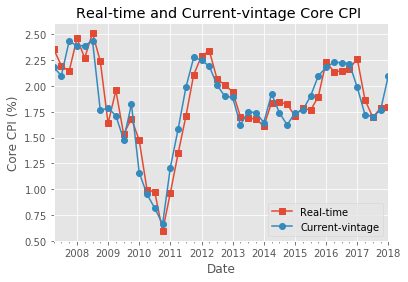

In [19]:
# real time inflation 
real_time = np.array(SPF_est['RTCPI'])

ax = SPF_est[['RTCPI','Inf1y_CPICore']].plot(style=['s-','o-'],
                                             figsize=([6,4]))
#plt.style.use('ggplot')
ax.set_title('Real-time and Current-vintage Core CPI ')
ax.set_xlabel('Date')
ax.set_ylabel('Core CPI (%)')
ax.legend(['Real-time', 'Current-vintage'])
plt.savefig('figures/ts_rev_realtime.png')

In [20]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
#SPF_est['Inf1yf_CPICore'].plot()
#plt.title('Realized 1-year-ahead Core CPI Inflation')

In [21]:
## preparing data moments

####################################################
#### specific to including more moments ###########
####################################################

exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var',
                        'SPFCPI_ATV','SPFCPI_FEATV']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var',
                        'ATV','FEATV']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var',
                       'SCE_ATV','SCE_FEATV']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var',
                        'ATV','FEATV']
data_moms_dct_SCE = dict(exp_data_SCE)

In [22]:
## estimating parameters 

################
## quarterly ###
#################

real_time_Q = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']

data_moms_dctQ = data_moms_dct_SPF


process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}
##############
## monthly ###
#############

real_time_M = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dctM = data_moms_dct_SCE


process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

### Rational Expectation 

In [23]:
#################
## RE for SPF #
###############

#RE_model = re(real_time = real_time_Q,
#              history = history_Q,
#              process_para = process_paraQ_est)
#RE_model.moments = ['Forecast','FE','Disg','Var','ATV','FEATV']
#RE_model.GetRealization(realized_CPIC)
#RE_model.GetDataMoments(data_moms_dct_SPF)
#re_dict = RE_model.Forecaster()

## plot RE forecast moments and data moments 

#re_data_plot = ForecastPlotDiag(re_dict,
#                                data_moms_dctQ)
#plt.savefig('figures/spf_re_est_diag.png')

### SE Estimation

moments used include ['FE', 'FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 0.817489
         Iterations: 10
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.818684
         Iterations: 98
         Function evaluations: 185
moments used include ['Disg', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.010815
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.083648
         Iterations: 61
         Function evaluations: 113
moments used include ['FE', 'FEVar', 'FEATV', 'Disg', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.820866
         Iterations: 11
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.823100
         Iterations: 60
         Function evaluations:

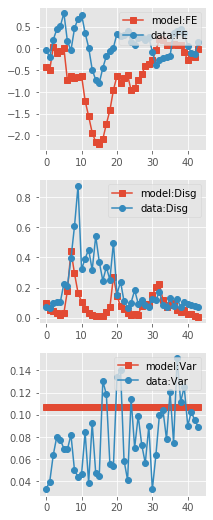

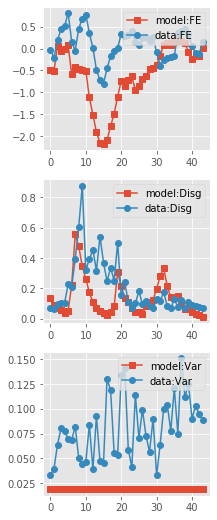

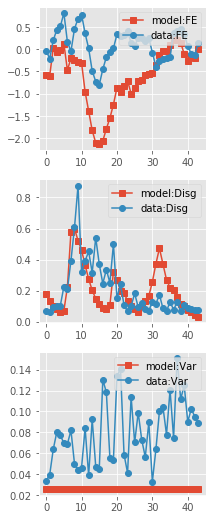

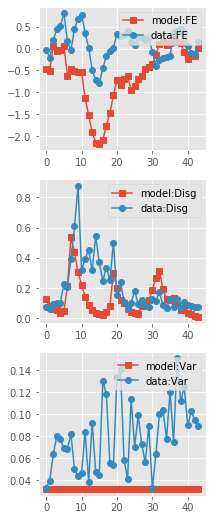

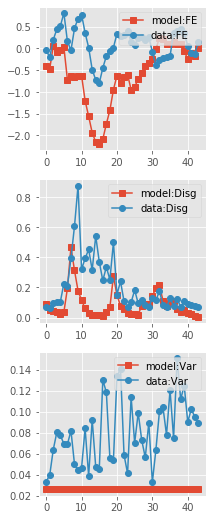

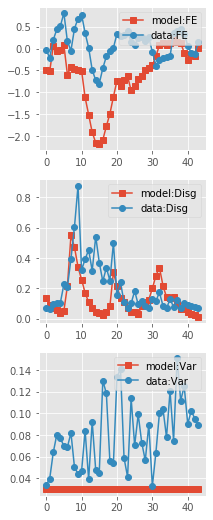

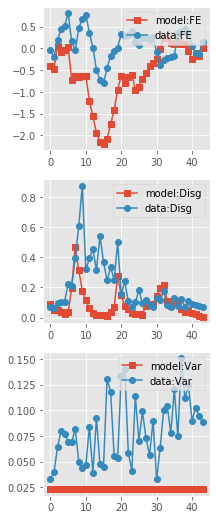

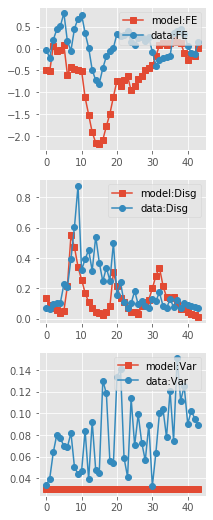

In [24]:
## SE loop SMM estimation over different choieces of moments for SPF

moments_choices_short = [['FE','FEVar','FEATV']]
moments_choices = [['FEVar','FEATV'],
                   ['DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []


## Initiate an instance
real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']
data_moms_dct = data_moms_dct_SPF
process_paraQ_est = {'rho':rhoQ_est,
                     'sigma':sigmaQ_est}
SE_model = seb(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est)
    
SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)

# loop starts from here for SPF 
for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    SE_model.moments = moments_to_use
    
    # only expectation
    SE_model.ParaEstimateSMM(method='Nelder-Mead',
                              para_guess = (0.5),
                              options={'disp':True})
    para_est_SPF_holder.append(SE_model.para_estSMM)
    SE_model.all_moments = ['FE','Disg','Var']
    SE_model.ForecastPlotDiag(how = 'SMM',
                              all_moms = True)
    plt.savefig('figures/spf_se_est_diag'+str(i)+'.png')
    
    # joint estimate
    SE_model.ParaEstimateSMMJoint(method='Nelder-Mead',
                                   para_guess =(0.5,0.6,0.1),
                                   options={'disp':True})
    para_est_SPF_joint_holder.append(SE_model.para_est_SMM_joint)
    SE_model.all_moments = ['FE','Disg','Var']
    SE_model.ForecastPlotDiag(how = 'SMMjoint',
                              all_moms = True)
    plt.savefig('figures/spf_se_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [25]:
## tabulate the estimates 
spf_se_est_para = pd.DataFrame(para_est_SPF_holder,columns=[r'SE: $\hat\lambda_{SPF}$(Q)'])
spf_se_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
                                     columns = [r'SE: $\hat\lambda_{SPF}$(Q)',
                                                r'SE: $\rho$',
                                                r'SE: $\sigma$'])

In [26]:
spf_se_est_para

,SE: $\hat\lambda_{SPF}$(Q)
0,0.471875
1,0.267285
2,0.471875
3,0.471875


In [27]:
spf_se_joint_est_para

,SE: $\hat\lambda_{SPF}$(Q),SE: $\rho$,SE: $\sigma$
0,0.364495,0.997943,0.083062
1,0.383970,0.996284,0.111462
2,0.363696,0.996725,0.104735
3,0.363708,0.996713,0.104773


moments used include ['FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 0.814140
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.786582
         Iterations: 45
         Function evaluations: 92
moments used include ['FEVar', 'DisgATV', 'DisgVar']
Optimization terminated successfully.
         Current function value: 0.708718
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.695274
         Iterations: 40
         Function evaluations: 86
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.908592
         Iterations: 11
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.884890
         Iterations: 45
         Function evaluations: 92
moments used incl

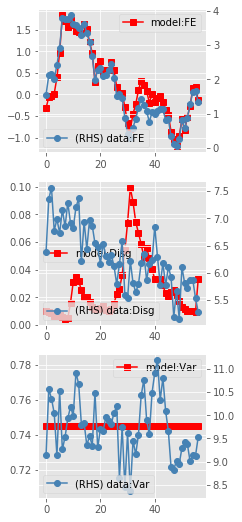

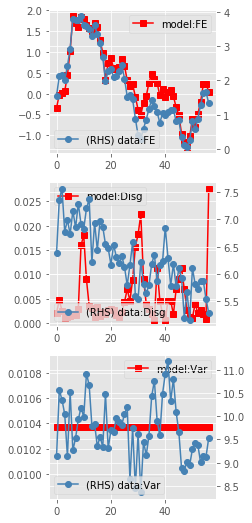

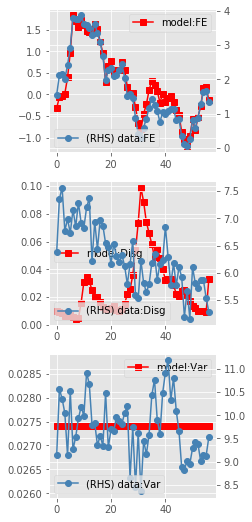

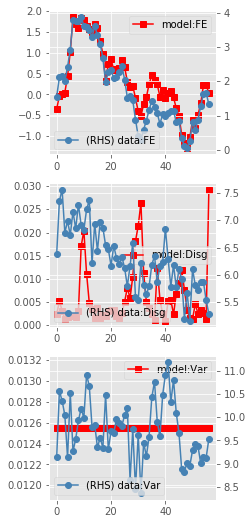

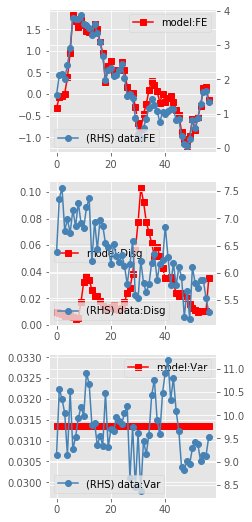

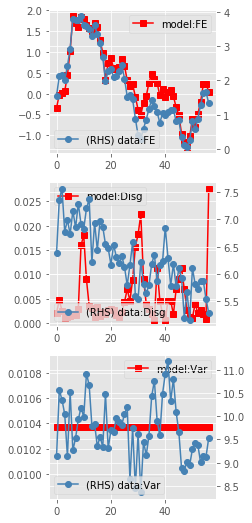

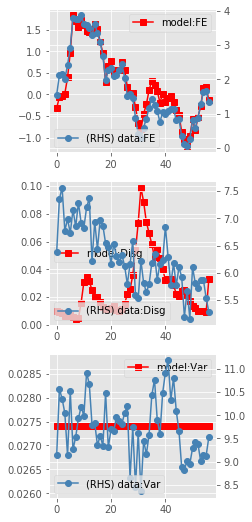

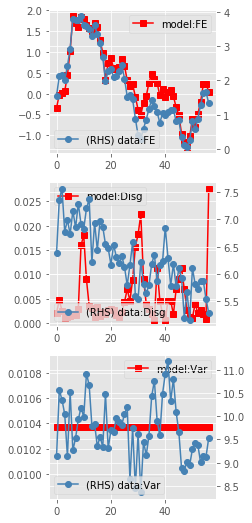

In [44]:
## SE loop estimation over different choieces of moments for SCE

moments_choices_short = [['FEVar','DisgATV','DisgVar']]
moments_choices = [['FEVar','FEATV'],
                   ['FEVar','DisgATV','DisgVar'],
                   ['FEVar','FEATV','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]

para_est_SCE_holder = []
para_est_SCE_joint_holder =[]


## Initiate an instance
real_time = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dct = data_moms_dct_SCE
process_paraM_est = {'rho':rhoM_est,
                     'sigma':sigmaM_est}
SE_model2 = seb(real_time = realized_CPI,
                history = history_M,
                process_para = process_paraM_est)

SE_model2.GetRealization(realized_CPI)
SE_model2.GetDataMoments(data_moms_dct)
    
for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    SE_model2.moments = moments_to_use
    
    ## only expectation
    SE_model2.ParaEstimateSMM(method='Nelder-Mead',
                               para_guess =(0.2),
                               options={'disp':True})
    para_est_SCE_holder.append(SE_model2.para_estSMM)
    SE_model2.all_moments = ['FE','Disg','Var']
    SE_model2.ForecastPlotDiag(how = 'SMM',
                               all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_se_est_diag'+str(i)+'.png')
    
    ## joint estimation
    
    SE_model2.ParaEstimateSMMJoint(method='Nelder-Mead',
                                    para_guess =(0.5,0.8,0.1),
                                    options={'disp':True})
    para_est_SCE_joint_holder.append(SE_model2.para_est_SMM_joint)
    SE_model2.all_moments = ['FE','Disg','Var']
    SE_model2.ForecastPlotDiag(how = 'SMMjoint',
                               all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_se_est_joint_diag'+str(i)+'.png')

print(para_est_SCE_holder)
print(para_est_SCE_joint_holder)

In [51]:
SE_model2.para_estSMM

array([0.20359375])

In [52]:
sce_se_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'SE: $\hat\lambda_{SCE}$(M)'])
sce_se_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
                                     columns = [r'SE: $\hat\lambda_{SCE}$(M)',
                                                r'SE: $\rho$',
                                                r'SE: $\sigma$'])

In [53]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
se_est_df = pd.concat([est_moms,
                       spf_se_est_para,
                       spf_se_joint_est_para,
                       sce_se_est_para,
                       sce_se_joint_est_para],
                      join = 'inner', axis=1)

In [54]:
sce_se_est_para

,SE: $\hat\lambda_{SCE}$(M)
0,0.203594
1,0.203594
2,0.203594
3,0.203594


In [55]:
sce_se_joint_est_para

,SE: $\hat\lambda_{SCE}$(M),SE: $\rho$,SE: $\sigma$
0,0.587601,0.985251,0.078866
1,0.557817,0.983961,0.084728
2,0.587601,0.985251,0.078866
3,0.587601,0.985251,0.078866


In [56]:
se_est_df.to_excel('tables/SE_Est.xlsx',
                   float_format='%.2f',
                   index=False)

### NI Estimation 

moments used include ['FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 0.026341
         Iterations: 70
         Function evaluations: 135
moments used include ['DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.044572
         Iterations: 141
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 1.892193
         Iterations: 147
         Function evaluations: 259
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.051777
         Iterations: 70
         Function evaluations: 134
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV', 'Var']
[array([25.31959749, 16.06879633]), array([4.71301726e+05, 8.46302246e-01]), array([25.31995157, 16.06770817]), array([9.16707606e+12, 2.37391147e+00])]
[array([0.9027207 , 1.08922988, 0.99999884, 0.00139524]), array([-1.736943

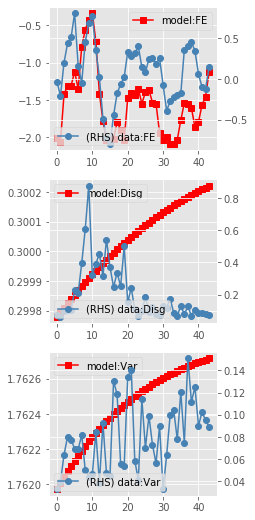

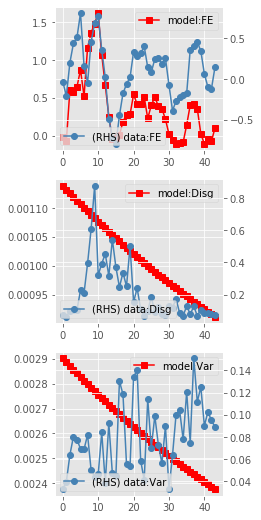

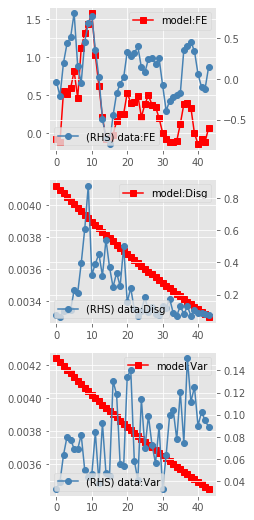

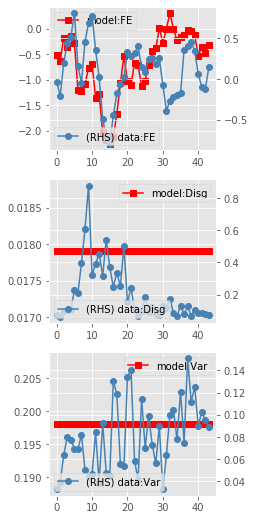

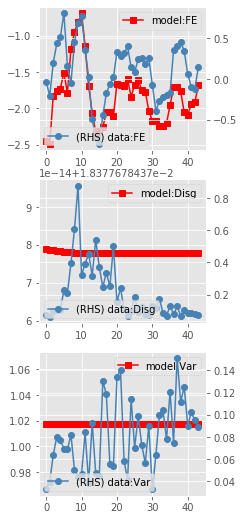

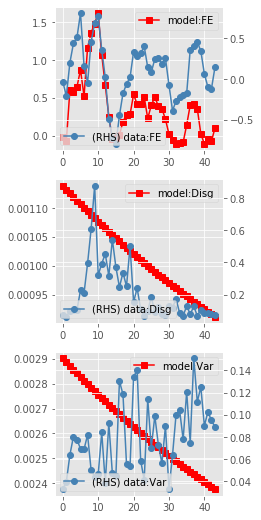

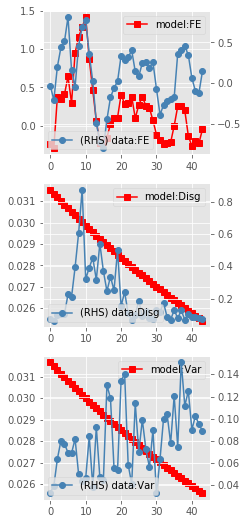

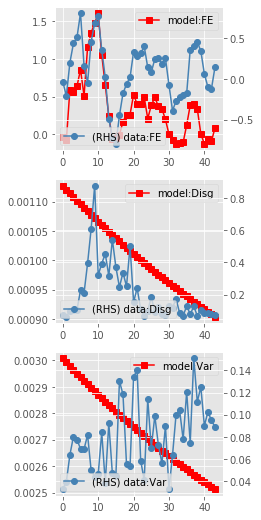

In [23]:
## NI loop estimation over different choieces of moments for SPF


moments_choices_short = [['Disg','DisgVar','DisgATV']]
moments_choices = [['FEVar','FEATV'],
                   ['Disg','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []


## initiate an instance 

real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']
data_moms_dct = data_moms_dct_SPF
process_paraQ_est = {'rho':rhoQ_est,
                     'sigma':sigmaQ_est}
NI_model = nib(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est)
#NI_model.SimulateSignals()
NI_model.GetRealization(realized_CPIC)
NI_model.GetDataMoments(data_moms_dct)
    
    
### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices_short):
    print("moments used include "+ str(moments_to_use))
    NI_model.moments = moments_to_use
   
    # only expectation
    NI_model.ParaEstimateSMM(method='Nelder-Mead',
                             para_guess =(0.5,0.5),
                             options={'disp':True})
    para_est_SPF_holder.append(NI_model.para_estSMM)
    NI_model.all_moments = ['FE','Disg','Var']
    #NI_model.ForecastPlotDiag(how = 'SMM',
    #                          all_moms = True,
    #                          diff_scale = True)
    #plt.savefig('figures/spf_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    NI_model.ParaEstimateSMMJoint(method='Nelder-Mead',
                                  para_guess =(0.5,0.5,0.8,0.1),
                                  options={'disp':True})
    para_est_SPF_joint_holder.append(NI_model.para_est_SMM_joint)
    NI_model.all_moments = ['FE','Disg','Var']
    #NI_model.ForecastPlotDiag(how = 'SMMjoint',
    #                          all_moms = True,
    #                          diff_scale = True)
    #plt.savefig('figures/spf_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [24]:
para_est_SPF_holder

[array([25.31959749, 16.06879633]),
 array([4.71301726e+05, 8.46302246e-01]),
 array([25.31995157, 16.06770817]),
 array([9.16707606e+12, 2.37391147e+00])]

In [25]:
para_est_SPF_joint_holder

[array([0.9027207 , 1.08922988, 0.99999884, 0.00139524]),
 array([-1.73694375, -0.16814157,  0.9110181 ,  0.42152354]),
 array([0.9027207 , 1.08922988, 0.99999884, 0.00139524]),
 array([0.8986987 , 1.09001254, 0.99999753, 0.00203387])]

In [26]:
## tabulate the estimates 
spf_ni_est_para = pd.DataFrame(para_est_SPF_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SPF}$',
                                        r'$\hat\sigma_{pr,SPF}$'])
spf_ni_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
                                     columns=[r'NI: $\hat\sigma_{pb,SPF}$',
                                              r'$\hat\sigma_{pr,SPF}$',
                                              r'NI: $\rho$',
                                              r'NI: $\sigma$'])

In [27]:
spf_ni_est_para

,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$"
0,2.531960e+01,16.068796
1,4.713017e+05,0.846302
2,2.531995e+01,16.067708
3,9.167076e+12,2.373911


In [28]:
spf_ni_joint_est_para

,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$",NI: $\rho$,NI: $\sigma$
0,0.902721,1.089230,0.999999,0.001395
1,-1.736944,-0.168142,0.911018,0.421524
2,0.902721,1.089230,0.999999,0.001395
3,0.898699,1.090013,0.999998,0.002034


moments used include ['FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 0.590876
         Iterations: 67
         Function evaluations: 126
moments used include ['DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.465956
         Iterations: 156
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: 0.531408
         Iterations: 97
         Function evaluations: 176
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 0.752497
         Iterations: 67
         Function evaluations: 126
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV', 'Var']
Optimization terminated successfully.
         Current function value: 9.663402
         Iterations: 71
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 9.666779
         

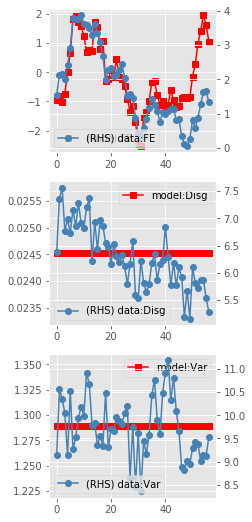

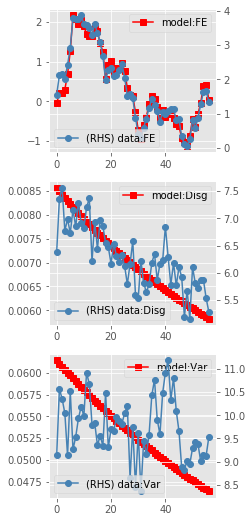

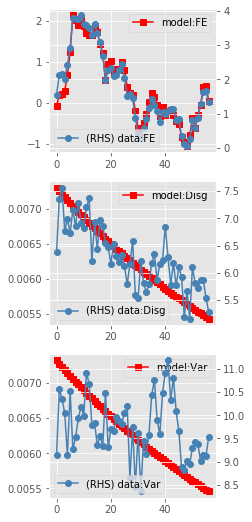

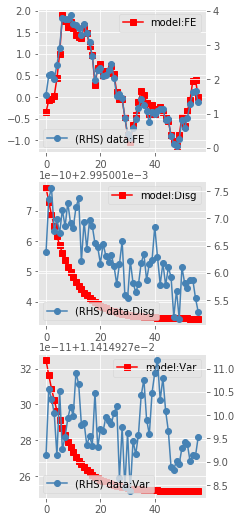

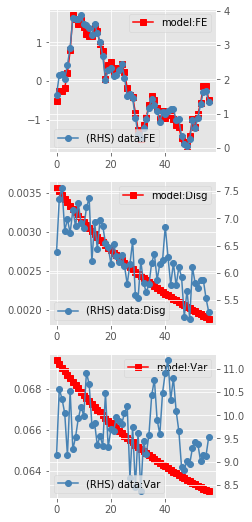

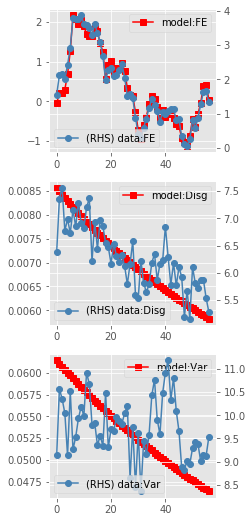

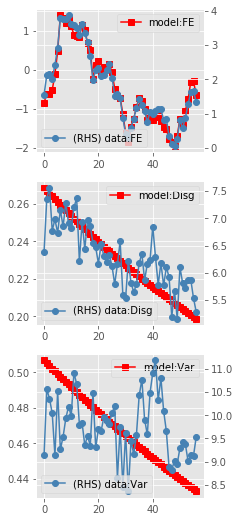

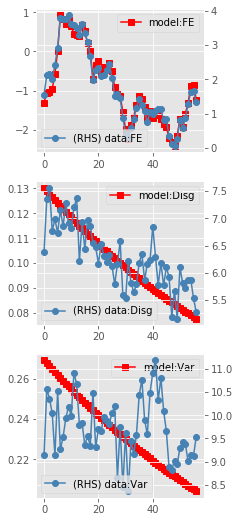

In [30]:
## NI loop estimation over different choieces of moments for SCE

moments_choices_short = [['FEVar','FEATV','DisgVar','DisgATV']]
moments_choices = [['FEVar','FEATV'],
                   ['DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]

para_est_SCE_holder = []
para_est_SCE_joint_holder = []


## initiate an instance 

real_time = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dct = data_moms_dct_SCE
process_paraM_est = {'rho':rhoM_est,
                     'sigma':sigmaM_est}
NI_model2 = nib(real_time = real_time,
               history = history_M,
               process_para = process_paraM_est)
#NI_model2.SimulateSignals()
NI_model2.GetRealization(realized_CPI)
NI_model2.GetDataMoments(data_moms_dct)
    
### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    NI_model2.moments = moments_to_use
    
    # only expectation
    NI_model2.ParaEstimateSMM(method='Nelder-Mead',
                              para_guess =(0.5,0.5),
                              options={'disp':True})
    para_est_SCE_holder.append(NI_model2.para_estSMM)
    NI_model2.all_moments = ['FE','Disg','Var']
    NI_model2.ForecastPlotDiag(how ='SMM',
                               all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_ni_est_diag'+str(i)+'.png')
    
    # joint estimate
    NI_model2.ParaEstimateSMMJoint(method='Nelder-Mead',
                                   para_guess =(0.5,0.5,0.8,0.1),
                                   options={'disp':True})
    para_est_SCE_joint_holder.append(NI_model2.para_est_SMM_joint)
    NI_model.all_moments = ['FE','Disg','Var']
    NI_model2.ForecastPlotDiag(how = 'SMMjoint',
                               all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_ni_est_joint_diag'+str(i)+'.png')
    
#print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [31]:
para_est_SCE_holder

[array([ 3.39824175, 15.39607147]),
 array([1.68519464e+05, 1.09169795e+00]),
 array([ 3.39824177, 15.39601031]),
 array([13.21517655, 59.96373127])]

In [32]:
para_est_SCE_joint_holder

[array([3.40059239e+00, 1.12926391e+01, 9.99998571e-01, 5.51915424e-04]),
 array([0.67470152, 0.58226832, 0.99672289, 0.0265312 ]),
 array([3.40059239e+00, 1.12926391e+01, 9.99998571e-01, 5.51915424e-04]),
 array([ 1.32151543e+01,  5.99640388e+01,  9.96720569e-01, -2.65426761e-02])]

In [33]:
## tabulate the estimates 
sce_ni_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SCE}$',
                                        r'$\hat\sigma_{pr,SCE}$'])
sce_ni_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
                                     columns=[r'NI: $\hat\sigma_{pb,SCE}$',
                                              r'$\hat\sigma_{pr,SCE}$',
                                              r'NI: $\rho$',
                                              r'NI: $\sigma$'])


In [34]:
sce_ni_est_para

,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$"
0,3.398242,15.396071
1,168519.463540,1.091698
2,3.398242,15.396010
3,13.215177,59.963731


In [35]:
sce_ni_joint_est_para

,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",NI: $\rho$,NI: $\sigma$
0,3.400592,11.292639,0.999999,0.000552
1,0.674702,0.582268,0.996723,0.026531
2,3.400592,11.292639,0.999999,0.000552
3,13.215154,59.964039,0.996721,-0.026543


In [36]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
ni_est_df = pd.concat([est_moms,
                       spf_ni_est_para,
                       spf_ni_joint_est_para,
                       sce_ni_est_para,
                       sce_ni_joint_est_para],
                      join='inner', axis=1)

In [37]:
ni_est_df.to_excel('tables/NI_Est.xlsx',
                   float_format='%.2f',
                   index = False)

In [45]:
### Estimate of Parameter Learning for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

process_paraQ_est = {'rho':rhoQ_est,
                    'sigma':sigmaQ_est}

PL_model = pl(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model.GetRealization(realized_CPIC)
PL_model.LearnParameters()
moms_pl_sim = PL_model.Forecaster()
PL_model.GetDataMoments(data_moms_dct)

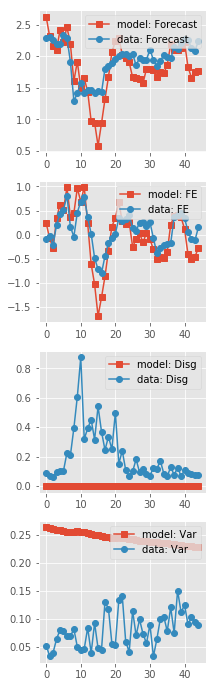

In [46]:
pl_plot = ForecastPlotDiag(moms_pl_sim,
                           data_moms_dct,
                           legends=['model','data'])

In [47]:
### Estimate of Parameter Learning for SCE

real_time = np.array(SCE_est['RTCPI'])
data_moms_dct2 = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

PL_model2 = pl(real_time = real_time,
              history = history_M,
              process_para = process_paraM_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model2.GetRealization(realized_CPI)
PL_model2.LearnParameters()
moms_pl_sim2 = PL_model2.Forecaster()
PL_model2.GetDataMoments(data_moms_dct2)

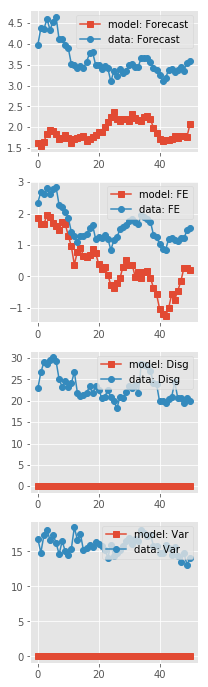

In [48]:
pl_plot = ForecastPlotDiag(moms_pl_sim2,
                           data_moms_dct2,
                           legends=['model','data'])

In [2]:
'''
NI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],
                'sigma_pr':sigmas_est_SPF[0][1],
                'var_init':sigmas_est_SPF[0][2]}

NI_model.exp_para = NI_model_sim_est
NI_model.SimulateSignals()
ni_sim_moms_dct = NI_model.Forecaster()
'''

"\nNI_model_sim_est = {'sigma_pb':sigmas_est_SPF[0][0],\n                'sigma_pr':sigmas_est_SPF[0][1],\n                'var_init':sigmas_est_SPF[0][2]}\n\nNI_model.exp_para = NI_model_sim_est\nNI_model.SimulateSignals()\nni_sim_moms_dct = NI_model.Forecaster()\n"

In [3]:
#NI_model.exp_para

In [4]:
'''
plt.figure(figsize=([3,13]))
for i,key in enumerate(ni_sim_moms_dct):
    plt.subplot(4,1,i+1)
    print(key)
    plt.plot(ni_sim_moms_dct[key],label='Model')
    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')
    plt.legend(loc=1)
'''

"\nplt.figure(figsize=([3,13]))\nfor i,key in enumerate(ni_sim_moms_dct):\n    plt.subplot(4,1,i+1)\n    print(key)\n    plt.plot(ni_sim_moms_dct[key],label='Model')\n    plt.plot(np.array(data_moms_dct_SPF[key]),label='Data')\n    plt.legend(loc=1)\n"